# Fraud Detection — Data Analytics Assignment

**File:** `Fraud_Detection_Data_Analytics.ipynb`

This notebook performs a full data analytics workflow on a fraud detection dataset and an auxiliary `customer_info.csv` dataset. Steps included:

1. Data loading & EDA
2. Data cleaning
3. Data integration (merge)
4. Data reduction
5. Data normalization
6. Hypothesis testing
7. Data visualization

> Notes: paths assume `fraud_detection.csv` and `customer_info.csv` are in the current working directory. If your files are large, the notebook will automatically sample for faster exploration; change parameters if you want to process the full dataset locally.

---

*Generated on: 2025-10-21 02:37:22 UTC*

## 1. Imports and configuration

We use standard data science libraries. Visualizations use `matplotlib` (no seaborn) to keep dependencies minimal. Scikit-learn is used for normalization.


In [11]:

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

FRAUD_FILE = "fraud_detection.csv"
CUSTOMER_FILE = "customer_info.csv"
SAMPLE_IF_LARGE = True
SAMPLE_SIZE = 200000
RANDOM_STATE = 42


## 2. Load datasets



In [2]:
print("Transaction data :")
fraud_df = pd.read_csv("fraud_detection_dataset.csv")
print(fraud_df.shape)
display(fraud_df.head())

print()

print("Customer data :")
customer_df = pd.read_csv("customer_integration_dataset.csv")
print(customer_df.shape)
display(customer_df.head())



Transaction data :
(1000, 11)


,time,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,15795,CASH_IN,60165.17,C3996840415,66838.54,6673.37,C2164547123,8440.09,68605.26,0,0
1,860,CASH_OUT,81920.69,C5321118252,146174.07,64253.38,C8560552146,99259.03,181179.72,0,0
2,76820,TRANSFER,88421.80,C1433539154,84002.20,0.00,C4102733279,108892.27,197314.07,0,0
3,54886,PAYMENT,22815.70,C6335342459,115671.95,92856.25,C5326715272,33688.11,56503.81,0,0
4,6265,CASH_IN,21212.36,C8344866777,166522.35,145309.99,C2302590308,152092.92,173305.28,0,0



Customer data :
(1000, 9)


,nameOrig,customer_age,account_type,region,tenure_years,credit_score,avg_monthly_trans,device_type,kyc_verified
0,C3996840415,43,Savings,North,15.3,693,38.1,Web,False
1,C5321118252,57,Savings,South,18.8,704,25.7,Branch,True
2,C1433539154,18,Checking,North,4.3,748,181.8,Web,True
3,C6335342459,43,Business,North,15.4,430,199.5,Branch,True
4,C8344866777,45,Checking,West,0.4,368,37.0,Branch,True


## 3. Data Cleaning

Steps:
- Rename columns if needed
- Convert datatypes (timestamps to datetime)
- Handle duplicates and missing values
- Basic outlier handling (for explanatory purposes)


In [3]:

print(fraud_df.columns)
print(fraud_df.dtypes)

fraud_df.columns = [c.strip() for c in fraud_df.columns]

time_cols = [c for c in fraud_df.columns if 'time' in c.lower() or 'date' in c.lower()]
print("Detected time-like columns:", time_cols)
for c in time_cols:
    try:
        fraud_df[c] = pd.to_datetime(fraud_df[c])
    except Exception:
        pass

dupes = fraud_df.duplicated().sum()
print("Duplicate rows in fraud_df:", dupes)
if dupes > 0:
    fraud_df = fraud_df.drop_duplicates().reset_index(drop=True)

print("\nMissing values (top 20):")
print(fraud_df.isna().sum().sort_values(ascending=False).head(20))

for c in fraud_df.columns:
    if fraud_df[c].dtype == 'object':
        fraud_df[c] = pd.to_numeric(fraud_df[c], errors='ignore')

if 'amount' in fraud_df.columns:
    q_low = fraud_df['amount'].quantile(0.001)
    q_high = fraud_df['amount'].quantile(0.999)
    fraud_df['amount_clipped'] = fraud_df['amount'].clip(lower=q_low, upper=q_high)
    print(f"Amount clipped to [{q_low:.2f}, {q_high:.2f}] for 'amount_clipped'.")


Index(['time', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
time                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
Detected time-like columns: ['time']
Duplicate rows in fraud_df: 0

Missing values (top 20):
time              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Amount clipped to [331.62, 99782.16] for 'amount_clipped'.


C:\Users\adilz\AppData\Local\Temp\ipykernel_31800\2836454558.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fraud_df[c] = pd.to_numeric(fraud_df[c], errors='ignore')


## 4. Data Integration

We merge `customer_info.csv` on `nameOrig`. If you want receiver info too, there's commented code to merge on `nameDest` (with suffixes).


In [4]:

# Merge datasets on 'nameOrig'
integrated_df = pd.merge(fraud_df, customer_df, on='nameOrig', how='left')
print(integrated_df.shape)
display(integrated_df)


(1000, 20)


,time,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_clipped,customer_age,account_type,region,tenure_years,credit_score,avg_monthly_trans,device_type,kyc_verified
0,1970-01-01 00:00:00.000015795,CASH_IN,60165.17,C3996840415,66838.54,6673.37,C2164547123,8440.09,68605.26,0,0,60165.17,43,Savings,North,15.3,693,38.1,Web,False
1,1970-01-01 00:00:00.000000860,CASH_OUT,81920.69,C5321118252,146174.07,64253.38,C8560552146,99259.03,181179.72,0,0,81920.69,57,Savings,South,18.8,704,25.7,Branch,True
2,1970-01-01 00:00:00.000076820,TRANSFER,88421.80,C1433539154,84002.20,0.00,C4102733279,108892.27,197314.07,0,0,88421.80,18,Checking,North,4.3,748,181.8,Web,True
3,1970-01-01 00:00:00.000054886,PAYMENT,22815.70,C6335342459,115671.95,92856.25,C5326715272,33688.11,56503.81,0,0,22815.70,43,Business,North,15.4,430,199.5,Branch,True
4,1970-01-01 00:00:00.000006265,CASH_IN,21212.36,C8344866777,166522.35,145309.99,C2302590308,152092.92,173305.28,0,0,21212.36,45,Checking,West,0.4,368,37.0,Branch,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1970-01-01 00:00:00.000002336,DEBIT,7774.16,C9425075725,190661.43,182887.27,C1550550858,162232.52,170006.68,0,0,7774.16,23,Business,South,7.0,697,59.9,Web,True
996,1970-01-01 00:00:00.000067779,CASH_IN,40760.23,C8431338540,14533.12,0.00,C5822912738,6565.10,47325.33,0,0,40760.23,27,Business,West,15.3,430,8.9,Web,True
997,1970-01-01 00:00:00.000019029,TRANSFER,40716.58,C3708910784,39818.68,0.00,C3661025253,93571.89,134288.47,0,0,40716.58,19,Savings,West,12.2,706,110.5,Branch,True
998,1970-01-01 00:00:00.000059201,CASH_OUT,6610.32,C9661556663,69564.47,62954.15,C8196356724,129324.23,135934.55,0,0,6610.32,41,Business,South,2.1,633,191.5,Web,True


## 5. Data Reduction

Techniques used:
- Remove irrelevant columns
- Feature selection (based on domain intuition)
- Optionally sample for modeling


In [5]:

cols_to_drop = [c for c in ['step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'] if c in integrated_df.columns]
print("Dropping columns (if present):", cols_to_drop)
integrated_reduced = integrated_df.drop(columns=cols_to_drop, errors='ignore')

selected_features = [
    'nameOrig','nameDest','amount_clipped' if 'amount_clipped' in integrated_reduced.columns else 'amount',
    'type' if 'type' in integrated_reduced.columns else None,
    'isFraud' if 'isFraud' in integrated_reduced.columns else None,
    'customer_age','account_type','region','tenure_years','credit_score','avg_monthly_trans','device_type','kyc_verified'
]
selected_features = [s for s in selected_features if s is not None]
selected_features = [s for s in selected_features if s in integrated_reduced.columns]
print("Selected features:", selected_features)

integrated_reduced = integrated_reduced[selected_features].copy()
print("Reduced dataframe shape:", integrated_reduced.shape)
integrated_reduced.head()


Dropping columns (if present): ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Selected features: ['nameOrig', 'nameDest', 'amount_clipped', 'type', 'isFraud', 'customer_age', 'account_type', 'region', 'tenure_years', 'credit_score', 'avg_monthly_trans', 'device_type', 'kyc_verified']
Reduced dataframe shape: (1000, 13)


,nameOrig,nameDest,amount_clipped,type,isFraud,customer_age,account_type,region,tenure_years,credit_score,avg_monthly_trans,device_type,kyc_verified
0,C3996840415,C2164547123,60165.17,CASH_IN,0,43,Savings,North,15.3,693,38.1,Web,False
1,C5321118252,C8560552146,81920.69,CASH_OUT,0,57,Savings,South,18.8,704,25.7,Branch,True
2,C1433539154,C4102733279,88421.80,TRANSFER,0,18,Checking,North,4.3,748,181.8,Web,True
3,C6335342459,C5326715272,22815.70,PAYMENT,0,43,Business,North,15.4,430,199.5,Branch,True
4,C8344866777,C2302590308,21212.36,CASH_IN,0,45,Checking,West,0.4,368,37.0,Branch,True


## 6. Data Normalization

Apply Min-Max scaling to numeric features used in modeling (e.g., `amount_clipped`, `credit_score`, `avg_monthly_trans`, `customer_age`).

In [6]:

num_cols = [c for c in ['amount_clipped','amount','credit_score','avg_monthly_trans','customer_age','tenure_years'] if c in integrated_reduced.columns]
print("Numeric columns to normalize:", num_cols)

scaler = MinMaxScaler()
if len(num_cols) > 0:
    integrated_reduced[num_cols] = scaler.fit_transform(integrated_reduced[num_cols].fillna(0))
integrated_reduced[num_cols].describe().T


Numeric columns to normalize: ['amount_clipped', 'credit_score', 'avg_monthly_trans', 'customer_age', 'tenure_years']


,count,mean,std,min,25%,50%,75%,max
amount_clipped,1000.0,0.500511,0.289071,0.0,0.256535,0.506354,0.752068,1.0
credit_score,1000.0,0.489993,0.292241,0.0,0.232696,0.486339,0.734062,1.0
avg_monthly_trans,1000.0,0.489188,0.294635,0.0,0.227109,0.474280,0.753729,1.0
customer_age,1000.0,0.492588,0.296423,0.0,0.235294,0.490196,0.745098,1.0
tenure_years,1000.0,0.504425,0.295157,0.0,0.250000,0.487500,0.775000,1.0


## 7. Hypothesis Testing

**Chi-square test**: Is fraud independent of "kyc_verified"?


In [23]:
# --- Corrected Chi-square calculation (step-by-step) ---
import numpy as np
import pandas as pd
from scipy.stats import chi2

# df = integrated_reduced  # ensure df exists and has the columns 'kyc_verified' and 'isFraud'

print("Hypothesis Testing (Chi-square test):")
print("H₀: Fraud occurrence is independent of KYC verification.")
print("H₁: Fraud occurrence depends on KYC verification.\n")

# 1) Build contingency table (observed frequencies)
contingency = pd.crosstab(df['kyc_verified'], df['isFraud']).astype(float)
observed = contingency.values        # observed counts matrix

# 2) Row totals, column totals, grand total
rows_sum = observed.sum(axis=1).reshape(-1, 1)   # column vector
cols_sum = observed.sum(axis=0).reshape(1, -1)   # row vector
total = observed.sum()                           # scalar

# 3) Expected frequencies under independence:
expected = (rows_sum @ cols_sum) / total

# 4) Avoid division by zero in expected
expected_safe = np.where(expected == 0, 1e-10, expected)

# 5) Compute chi-square statistic manually
chi_square_stat = float(np.sum((observed - expected) ** 2 / expected_safe))

# 6) Degrees of freedom
r, c = observed.shape
dof = (r - 1) * (c - 1)

# 7) Compute p-value from chi-square distribution (p = P(Chi2 >= statistic))
chi_square_critical = float(chi2.sf(chi_square_stat, df=dof))  # this is the p-value

# 8) Show observed/expected and results
print("Observed counts:\n", contingency.astype(int), "\n")
print("Expected counts (rounded):\n", np.round(expected, 2), "\n")
print(f"chi_square_stat = {chi_square_stat:.6f}")
print(f"degrees_of_freedom = {dof}")
print(f"chi_square_critical (p-value) = {chi_square_critical:.6f}\n")

# 9) Check chi-square assumptions (expected cell counts)
small_expected = (expected < 5).sum()
print(f"Number of expected cells with count < 5: {small_expected}\n")

# 10) Decision using p-value (alpha = 0.05)
alpha = 0.05
if chi_square_critical < alpha:
    print(f"Result: p-value = {chi_square_critical:.6f} < {alpha} → Reject H₀.")
    print("Interpretation: There is a statistically significant association between KYC verification and fraud.")
else:
    print(f"Result: p-value = {chi_square_critical:.6f} >= {alpha} → Fail to reject H₀.")
    print("Interpretation: No evidence of association between KYC verification and fraud.")


Hypothesis Testing (Chi-square test):
H₀: Fraud occurrence is independent of KYC verification.
H₁: Fraud occurrence depends on KYC verification.

Observed counts:
 isFraud         0   1
kyc_verified         
False         110   5
True          848  37 

Expected counts (rounded):
 [[110.17   4.83]
 [847.83  37.17]] 

chi_square_stat = 0.007057
degrees_of_freedom = 1
chi_square_critical (p-value) = 0.933050

Number of expected cells with count < 5: 1

Result: p-value = 0.933050 >= 0.05 → Fail to reject H₀.
Interpretation: No evidence of association between KYC verification and fraud.


## 8. Data Visualization

Basic plots to support the analysis. All plots use `matplotlib`.


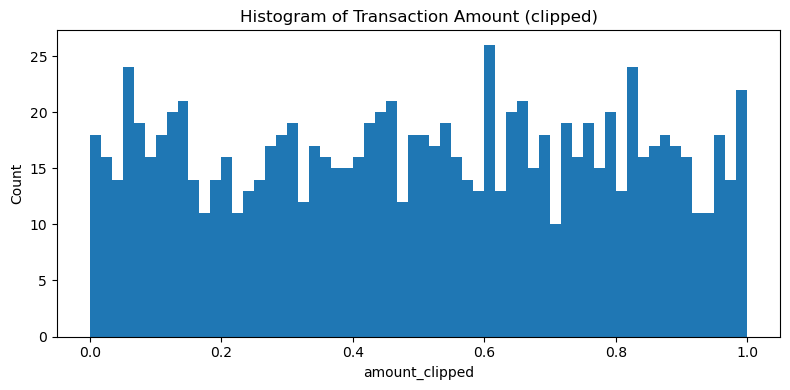

<Figure size 600x400 with 0 Axes>

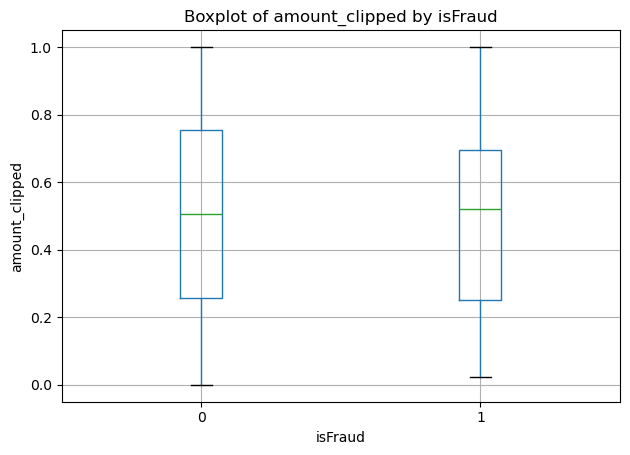

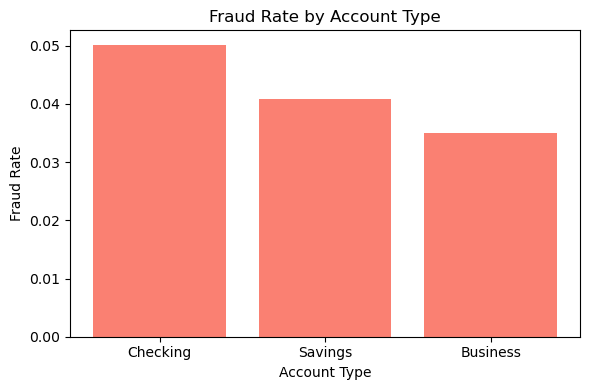

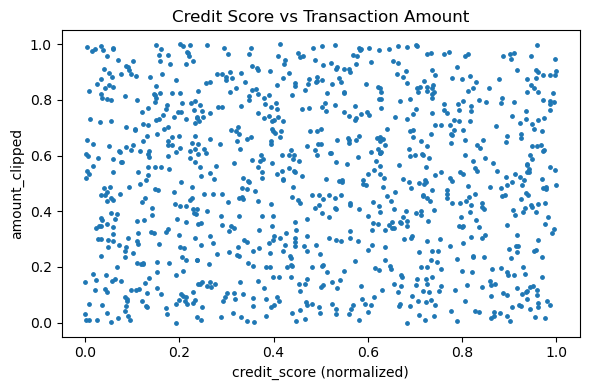

In [13]:

amt_col = 'amount_clipped' if 'amount_clipped' in integrated_reduced.columns else ('amount' if 'amount' in integrated_reduced.columns else None)
if amt_col:
    plt.figure(figsize=(8,4))
    plt.hist(integrated_reduced[amt_col].dropna(), bins=60)
    plt.title('Histogram of Transaction Amount (clipped)')
    plt.xlabel(amt_col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

if amt_col and 'isFraud' in integrated_reduced.columns:
    plt.figure(figsize=(6,4))
    integrated_reduced.boxplot(column=amt_col, by='isFraud')
    plt.suptitle('')
    plt.title(f'Boxplot of {amt_col} by isFraud')
    plt.xlabel('isFraud')
    plt.ylabel(amt_col)
    plt.tight_layout()
    plt.show()

if 'account_type' in integrated_reduced.columns and 'isFraud' in integrated_reduced.columns:
    fraud_rate = integrated_reduced.groupby('account_type')['isFraud'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    plt.bar(fraud_rate.index, fraud_rate.values,color = "salmon")
    plt.title('Fraud Rate by Account Type')
    plt.xlabel('Account Type')
    plt.ylabel('Fraud Rate')
    plt.tight_layout()
    plt.show()

if 'credit_score' in integrated_reduced.columns and amt_col:
    plt.figure(figsize=(6,4))
    plt.scatter(integrated_reduced['credit_score'], integrated_reduced[amt_col], s=6)
    plt.title('Credit Score vs Transaction Amount')
    plt.xlabel('credit_score (normalized)')
    plt.ylabel(amt_col)
    plt.tight_layout()
    plt.show()


In [18]:
df

,nameOrig,nameDest,amount_clipped,type,isFraud,customer_age,account_type,region,tenure_years,credit_score,avg_monthly_trans,device_type,kyc_verified
0,C3996840415,C2164547123,0.601641,CASH_IN,0,0.490196,Savings,North,0.765,0.715847,0.168724,Web,False
1,C5321118252,C8560552146,0.820398,CASH_OUT,0,0.764706,Savings,South,0.940,0.735883,0.104938,Branch,True
2,C1433539154,C4102733279,0.885769,TRANSFER,0,0.000000,Checking,North,0.215,0.816029,0.907922,Web,True
3,C6335342459,C5326715272,0.226083,PAYMENT,0,0.490196,Business,North,0.770,0.236794,0.998971,Branch,True
4,C8344866777,C2302590308,0.209961,CASH_IN,0,0.529412,Checking,West,0.020,0.123862,0.163066,Branch,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C9425075725,C1550550858,0.074837,DEBIT,0,0.098039,Business,South,0.350,0.723133,0.280864,Web,True
996,C8431338540,C5822912738,0.406520,CASH_IN,0,0.176471,Business,West,0.765,0.236794,0.018519,Web,True
997,C3708910784,C3661025253,0.406081,TRANSFER,0,0.019608,Savings,West,0.610,0.739526,0.541152,Branch,True
998,C9661556663,C8196356724,0.063134,CASH_OUT,0,0.450980,Business,South,0.105,0.606557,0.957819,Web,True


The Correlation Matrix:


,amount_clipped,customer_age,credit_score,avg_monthly_trans,kyc_verified,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,account_type_Checking,account_type_Savings,region_North,region_South,region_West
amount_clipped,1.000000,0.007482,-0.005852,-0.000296,0.046036,-0.006349,-0.001236,0.013109,-0.015465,-0.018884,0.016283,-0.012145,0.050452,-0.040194,-0.012597
customer_age,0.007482,1.000000,-0.008727,0.037810,-0.001653,-0.010599,0.034118,0.030597,0.012552,-0.085146,-0.041993,0.012251,-0.009651,0.028390,-0.039289
credit_score,-0.005852,-0.008727,1.000000,0.006678,-0.030226,0.006396,-0.001361,-0.038510,-0.014919,0.052712,-0.001133,0.004099,-0.001948,0.041568,-0.029452
avg_monthly_trans,-0.000296,0.037810,0.006678,1.000000,-0.028227,0.000974,-0.001223,-0.002847,0.010683,0.007553,-0.034929,0.008717,0.052968,-0.003605,-0.042584
kyc_verified,0.046036,-0.001653,-0.030226,-0.028227,1.000000,-0.002657,-0.014336,0.009491,0.014800,0.006228,-0.033209,-0.002894,-0.010275,0.039655,-0.007364
isFraud,-0.006349,-0.010599,0.006396,0.000974,-0.002657,1.000000,0.036557,-0.001339,-0.016957,-0.070063,0.029088,-0.003811,-0.000934,-0.013223,0.004777
type_CASH_OUT,-0.001236,0.034118,-0.001361,-0.001223,-0.014336,0.036557,1.000000,-0.239157,-0.243754,-0.249856,-0.007638,-0.002035,-0.049362,-0.001938,-0.015384
type_DEBIT,0.013109,0.030597,-0.038510,-0.002847,0.009491,-0.001339,-0.239157,1.000000,-0.243754,-0.249856,0.019126,0.008847,0.069297,-0.053549,-0.027057
type_PAYMENT,-0.015465,0.012552,-0.014919,0.010683,0.014800,-0.016957,-0.243754,-0.243754,1.000000,-0.254659,0.013434,-0.044544,-0.004457,0.040054,-0.000854
type_TRANSFER,-0.018884,-0.085146,0.052712,0.007553,0.006228,-0.070063,-0.249856,-0.249856,-0.254659,1.000000,-0.021758,-0.009678,0.007629,-0.000346,0.010438


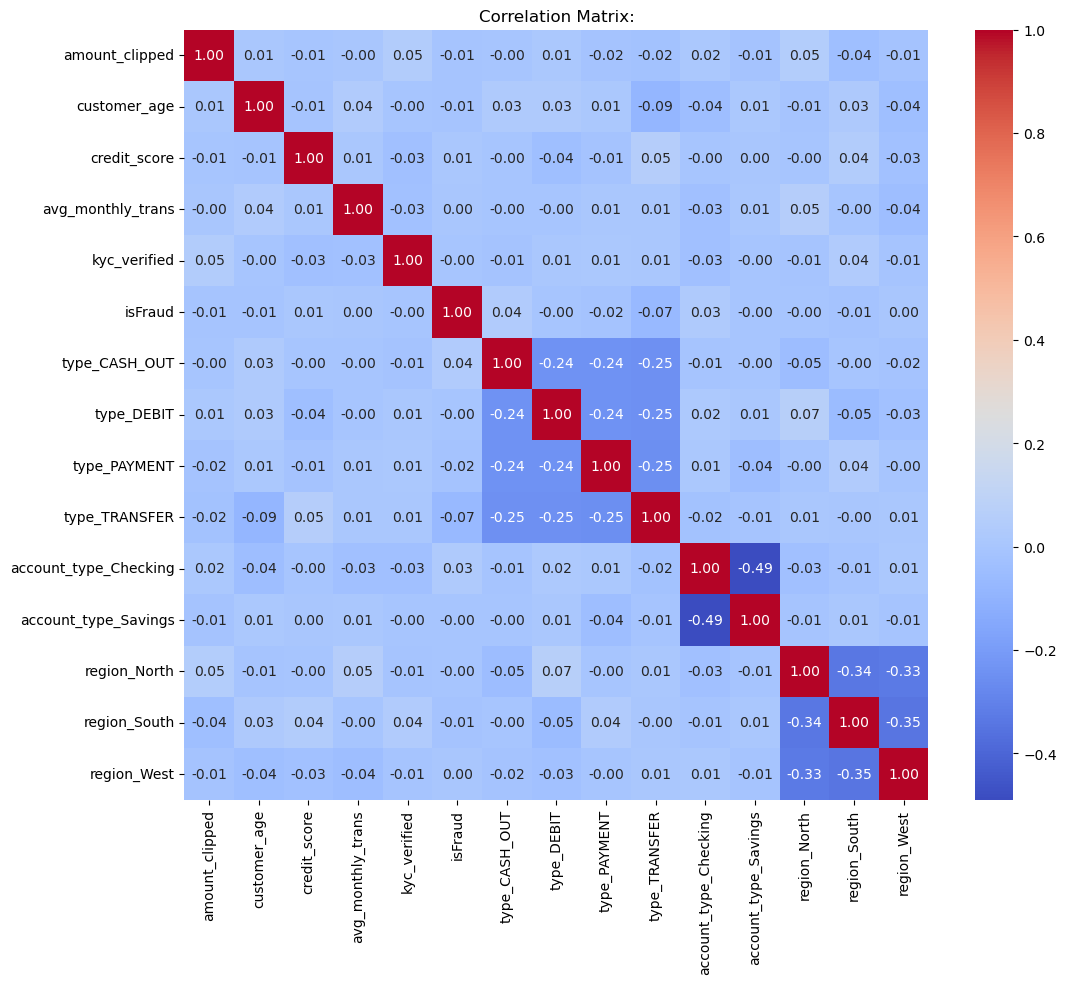

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
cols = ["amount_clipped", "type", "customer_age", "account_type", "region",
        "credit_score", "avg_monthly_trans", "kyc_verified", "isFraud"]

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df[cols], drop_first=True)

# Compute correlation matrix
corr = df_encoded.corr()

# Display and plot
print("The Correlation Matrix:")
display(corr)

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix:")
plt.show()

## 9. Save integrated & reduced dataset

We save the processed dataset for reuse in modeling/analysis.


In [9]:

output_name = "integrated_fraud_reduced.csv"
integrated_reduced.to_csv(output_name, index=False)
print("Saved reduced integrated dataset to:", output_name)


Saved reduced integrated dataset to: integrated_fraud_reduced.csv
